In [1]:
###purpose: Get block-skipping junction reads in nascent RNA - Figure 4F
###input: exon block coordinates (output from script 5_block_coords_and_flanking_exon_coords.ipynb)
###       and Stab
###date: 04/29/2025


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
blocks= pd.read_csv('exon_block_coordinates_ups_dns.csv')

In [4]:
##open SJ.out.files and give column names###

# Define column names
column_names = [
    "chr", "intron_start", "intron_end", "strand",
    "intron_motif", "junction_ann", "un_map_reads",
    "mult_map_reads", "max_spli_align_ovh"
]

# List of file names and desired variable names
file_names = ["ctr1_dmso_nRNASJ.out.tab", "ctr2_dmso_nRNASJ.out.tab", "ctr3_dmso_nRNASJ.out.tab", "eif4a3_kd1_nRNASJ.out.tab", "eif4a3_kd2_nRNASJ.out.tab", "eif4a3_kd3_nRNASJ.out.tab"]
var_names = ["ctr1", "ctr2", "ctr3", "kd1", "kd2", "kd3"]

# Loop through files and read each into a DataFrame with the specified variable name
for file, name in zip(file_names, var_names):
    globals()[name] = pd.read_csv(file, sep="\t", header=None, names=column_names)


In [5]:
###get junction reads and normalize to sum of junction reads (un_map_reads),
### multiply by 1M to get RPMvalues####

# List of DataFrames for ctr and kd files
dataframes = [ctr1, ctr2, ctr3, kd1, kd2, kd3]
df_names = ["ctr1", "ctr2", "ctr3", "kd1", "kd2", "kd3"]

# Function to retrieve and normalize mapped reads based on matching conditions with tolerance of 2 nucleotides
def get_junction_reads_rpm(blocks_row, df, total_reads):
    match = df[(df['chr'] == blocks_row['chr']) &
               (abs(df['intron_start'] - (blocks_row['end_ups_exon'] + 1)) <= 2) &
               (abs(df['intron_end'] - (blocks_row['start_dns_exon'] - 1)) <= 2)]
    
    if not match.empty:
        return (match['un_map_reads'].values[0] / total_reads) * 1_000_000
    else:
        return 0

# Loop through each DataFrame, calculate total reads, and add normalized column to blocks DataFrame
for df, name in zip(dataframes, df_names):
    total_reads = df['un_map_reads'].sum()  # Calculate total reads for normalization
    blocks[f"jr_{name}"] = blocks.apply(lambda row: get_junction_reads_rpm(row, df, total_reads), axis=1)



In [6]:
# Calculate mean RPM for control (ctr) and knockdown (kd) samples
blocks['ctr_mean'] = blocks[['jr_ctr1', 'jr_ctr2', 'jr_ctr3']].mean(axis=1)
blocks['kd_mean'] = blocks[['jr_kd1', 'jr_kd2', 'jr_kd3']].mean(axis=1)


In [9]:
blocks = blocks[(blocks['ctr_mean'] != 0) | (blocks['kd_mean'] != 0)]


In [11]:
# blocks.to_csv('nRNA_block_junctions_detected.csv', index=False)

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_82431/2586344621.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=melted_blocks, x='Condition', y='RPM', palette=palette, inner="box", cut=0)


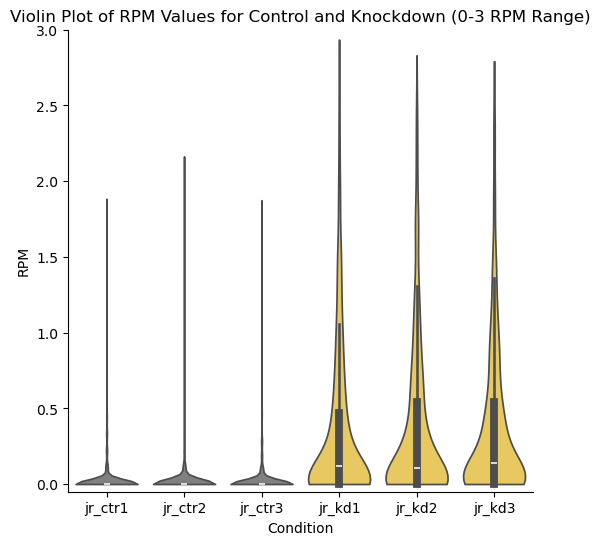

In [8]:
# Filter the data to include only RPM values in the range 0 to 3 for the six categories
filtered_blocks = blocks[
    (blocks['jr_ctr1'] <= 3) & (blocks['jr_ctr2'] <= 3) & (blocks['jr_ctr3'] <= 3) &
    (blocks['jr_kd1'] <= 3) & (blocks['jr_kd2'] <= 3) & (blocks['jr_kd3'] <= 3)
]

# Melt the data for easier plotting with seaborn
melted_blocks = filtered_blocks.melt(
    value_vars=['jr_ctr1', 'jr_ctr2', 'jr_ctr3', 'jr_kd1', 'jr_kd2', 'jr_kd3'],
    var_name='Condition',
    value_name='RPM'
)

# Define custom colors: Gray for Control, Yellow for Knockdown
palette = {
    'jr_ctr1': 'gray',
    'jr_ctr2': 'gray',
    'jr_ctr3': 'gray',
    'jr_kd1': '#FFD449',
    'jr_kd2': '#FFD449',
    'jr_kd3': '#FFD449'
}

# Create the violin plot
plt.figure(figsize=(6, 6))  # Adjust figure size for better visualization
sns.violinplot(data=melted_blocks, x='Condition', y='RPM', palette=palette, inner="box", cut=0)

# Add labels and title
plt.ylim(-0.05, 3)
plt.title('Violin Plot of RPM Values for Control and Knockdown (0-3 RPM Range)')
plt.xlabel('Condition')
plt.ylabel('RPM')

# Remove spines for a cleaner look
sns.despine()

# Save the plot
plt.savefig('nRNA_block_junction_reads_violin_3reps.png', dpi=300)
plt.savefig('nRNA_block_junction_reads_violin_3reps.pdf', dpi=300)

# Show the plot
plt.show()
